# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import re
from sklearn.metrics import f1_score
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/datasets/toxic_comments.csv')
display(df.info())
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Наш датасет состоит всего из двух столбцов, а это - текст комментария и разметка на положительный и отрицательный. Текс у нас не обработанный нужно этим заняться. Для начала посмотрим как у нас распределен целевой признак, далее займемся предобработкой текста.

 Распределение целевого признака 


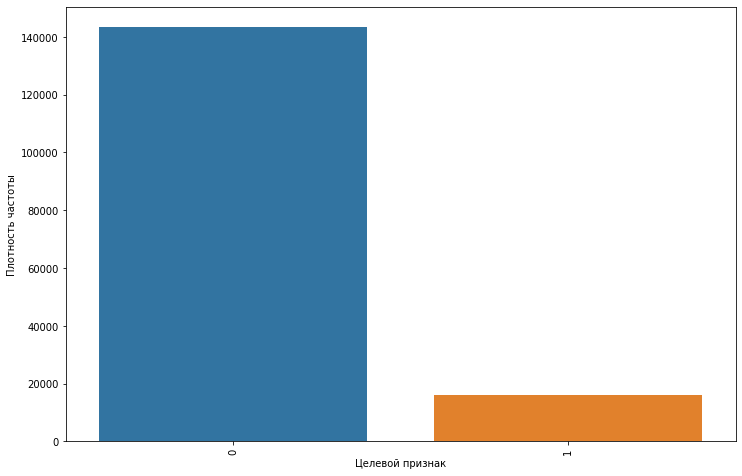

In [4]:
print('\033[1m Распределение целевого признака \033[0m')
fig, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation=90)
sns.countplot(df['toxic'])
plt.xlabel('Целевой признак')
plt.ylabel('Плотность частоты')
plt.show()

In [5]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Положительных комментариев в нас в разы больше чем негативных, это нужно будет учесть в дальнейшем при обучении моделей

Так как текст комментариев сейчас не пригоден для анализа, его нужно почистить от лишних символов и лемматизировать этим и займемся

In [7]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [9]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemm_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lemm_list])      
    return lemm_text

In [10]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text)
    clear_text = clear_text.lower().split()
    return ' '.join(clear_textxt)

Выведем первую строчку наших комментариев и сравним ее с лемматиризоранной и отчищенной от лишнего

In [11]:
df.loc[0, 'text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [12]:
lemmatize(clear_text(df.loc[0, 'text']))

'explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now'

Лемматизация выполнена, у нас получился пригодный текст для дальнейшего анализа, лишние символы убраны

In [13]:
%%time
df['lemm_text'] = df['text'].apply(lambda text: lemmatize(clear_text(text)))

CPU times: user 18min 19s, sys: 1min 47s, total: 20min 7s
Wall time: 20min 8s


In [14]:
df.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


Разделим наши данные на тренировочную и тестовую выборки. Для теста оставим 25% датасета

In [15]:
train_features, test_features, train_target, test_target = train_test_split(
    df['lemm_text'], df['toxic'], test_size=0.25, random_state=42)

In [16]:
train_features.shape, test_features.shape, train_target.shape, test_target.shape

((119678,), (39893,), (119678,), (39893,))

Мы уже очистили от лишнего наши данные и привели текст к начальной форме, теперь необходимо убрать лишние слова, так как при дальнейшем превращении их в признаки они будут нам мешать и модель может обучиться не верно

In [17]:
train_corpus = train_features.values
test_corpus = test_features.values

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
stop_words = set(stopwords.words('english'))

## Векторизация данных методом TFIDF

In [20]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
train_tf_idf = count_tf_idf.fit_transform(train_corpus)
test_tf_idf = count_tf_idf.transform(test_corpus)

In [21]:
print("Размер обучающей матрицы:", train_tf_idf.shape), 
print("Размер тестовой матрицы:", test_tf_idf.shape)

Размер обучающей матрицы: (119678, 127788)
Размер тестовой матрицы: (39893, 127788)


Напишем функцию для проверки нашей модели. Для этого мы будем использвать метрику **F1**

In [22]:
def scoring(fitted_model):
    test_pred = fitted_model.predict(test_tf_idf)
    test_f1 = f1_score(test_target, test_pred)
    
    print('F1 на тестовой выборке: {:.3f}'.format(test_f1))

## Обучение модели

Для данной задачи мы обучим модель логистической регресси, она проста, но в тоже время эффективна. Так как наш заказчик это интернет магазин, разумнее истользовать простую модель. В дальнейшем заказчик сможет поддерживать ее в работоспособном состоянии и ее не так будет сложно доработать, нежели более сложные модели, например, Catboost Regression

In [23]:
cv = ShuffleSplit(n_splits=2, test_size=0.25, random_state=42)

In [24]:
log_reg = LogisticRegression(random_state=42, class_weight='balanced')

In [25]:
log_reg_params = {'C': np.linspace(0.0001, 100, 10)}

In [26]:
%%timea
log_reg_grid = GridSearchCV(log_reg, log_reg_params, scoring='f1')
log_reg_grid.fit(train_tf_idf, train_target)

CPU times: user 8min 5s, sys: 7min 40s, total: 15min 45s
Wall time: 15min 46s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000e-04, 1.11112e+01, 2.22223e+01, 3.33334e+01, 4.44445e+01,
       5.55556e+01, 6.66667e+01, 7.77778e+01, 8.88889e+01, 1.00000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [27]:
print('best parameters: ', log_reg_grid.best_params_)
print('best scores: ', log_reg_grid.best_score_)

best parameters:  {'C': 11.1112}
best scores:  0.7535383006507084


In [28]:
log_reg_grid.best_estimator_

LogisticRegression(C=11.1112, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
%%time
scoring(log_reg_grid.best_estimator_)

F1 на тестовой выборке: 0.765
CPU times: user 18 ms, sys: 861 µs, total: 18.9 ms
Wall time: 17 ms


Мы получили не плохой результат на тестовой выборке, значение метрики F1 = 0.765

## Выводы

Мы разработали и обучили модель для классификации комментариев на негативные и положительные. Наш заказчик интернет-магазин "Викишоп" только запускает свой сервис и на данном этапе мы рекомендуем ему использовать именно данную модель, так как она проста в интеграции и первичной настройке. В дальнейшем рекомендация для улучшения качества сервиса использовать модели градиентного бустинка, а именно Catboost или Lightgbm.